In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [3]:
# Load the dataset
df = pd.read_parquet("data.parquet")  # Change if needed
df['period_start'] = pd.to_datetime(df['period_start'])  # Ensure date column is datetime
df.set_index('period_start', inplace=True)

# Split data into train and test
train = df.iloc[:-6]
test = df.iloc[-6:]

# Univariate ARIMA model
arima_model = ARIMA(train['value'], order=(5,1,0))  # Adjust order as needed
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=36)

# Prepare data for LSTM
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['value']])
train_scaled = scaler.transform(train[['value']])
test_scaled = scaler.transform(test[['value']])

# Create sequences
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

In [4]:
# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Forecast next 36 months
X_input = train_scaled[-12:].reshape(1, 12, 1)
lstm_forecast = []
for _ in range(36):
    pred = model.predict(X_input)
    lstm_forecast.append(pred[0,0])
    X_input = np.roll(X_input, -1, axis=1)
    X_input[0, -1, 0] = pred

# Inverse transform results
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1,1))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8834/8834 ━━━━━━━━━━━━━━━━━━━━ 101s 11ms/step - loss: 7.7029e-05
Epoch 2/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 96s 11ms/step - loss: 3.3223e-05
Epoch 3/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step - loss: 3.4945e-05
Epoch 4/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 99s 11ms/step - loss: 2.8247e-05
Epoch 5/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - loss: 3.3102e-05
Epoch 6/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - loss: 2.2330e-05
Epoch 7/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 141s 11ms/step - loss: 2.0706e-05
Epoch 8/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 148s 12ms/step - loss: 1.7865e-05
Epoch 9/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 102s 12ms/step - loss: 2.1257e-05
Epoch 10/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 1.7812e-05
Epoch 11/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 136s 11ms/step - loss: 1.5587e-05
Epoch 12/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 154s 12ms/step - loss: 1.6414e-05
Epoch 13/50
8834/8834 ━━━━━━━━━━━━━━━━━━━━ 98s 11ms/step - loss: 2.3675e-05
Epoch 14/50
8834/8834 ━

<ipython-input-4-404b8625232f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_input[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

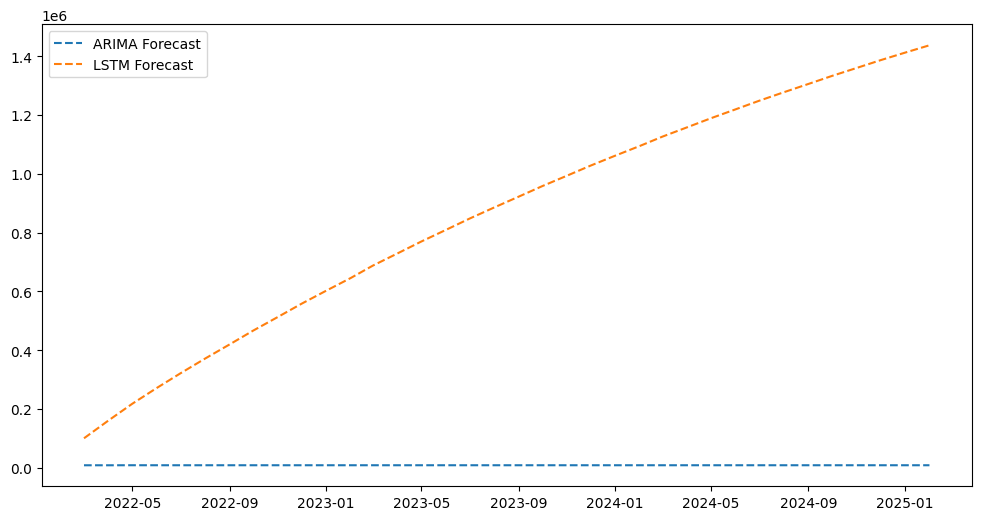

In [6]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(df.index[-36:], arima_forecast, label='ARIMA Forecast', linestyle='dashed')
plt.plot(df.index[-36:], lstm_forecast, label='LSTM Forecast', linestyle='dashed')
plt.legend()
plt.show()